In [1810]:
import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px  # Для создания интерактивных визуализаций
import plotly.graph_objects as go  # Для кастомных графиков
from plotly.subplots import make_subplots  # Для создания subplots
import warnings  # Для управления предупреждениями
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import random
import math
warnings.filterwarnings('ignore')  # Игнорировать предупреждения для чистоты вывода

# Загрузка датасета из CSV файла
# header=0: первая строка содержит названия колонок
# delim_whitespace=True: данные разделены пробелами

df = pd.read_csv('data_tms.csv', header=0, sep=',')
df_test = df.copy()

# Проверим структуру данных
print("Размер датасета (строки, колонки):", df.shape)
print("\nПервые 10 строк датасета:")
df.head(10)


Размер датасета (строки, колонки): (891, 12)

Первые 10 строк датасета:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Смотрим качество данных

In [1811]:
print("Названия колонок:")
print(df.columns.tolist())
print("\nИнформация о датасете:")
df.info()  # Показываем информацию о типах данных и наличии пропусков

Названия колонок:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1812]:
# Проверка на пропущенные значения
# isnull(): возвращает булеву маску где True означает пропущенное значение
# sum(): суммирует True значения (1) по каждой колонке
missing_values = df.isnull().sum()
print("Пропущенные значения в каждой колонке:")
print(missing_values)

Пропущенные значения в каждой колонке:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Пустые Embarked

In [1813]:
df[df['Embarked'].isnull()]  # Проверяем строки с пропущенным Embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Заполняем пустые значения вокзалов отправления

In [1814]:
print("Распределение вокзалов до обработки:")
print(df['Embarked'].value_counts())


most_common_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(most_common_embarked, inplace=True)
df['Embarked_num'] = df['Embarked'].map({
    'S': 0, 
    'C': 1, 
    'Q': 2
}).astype(int)
df.drop(columns=['Embarked'], inplace=True) # Удаляем оригинальную колонку

print("\nРаспределение  после обработки:")
print(df['Embarked_num'].value_counts())

Распределение вокзалов до обработки:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Распределение  после обработки:
Embarked_num
0    646
1    168
2     77
Name: count, dtype: int64


Пустые Age

In [1815]:
print(df[df['Age'].isnull()].sample(10))  # Случайные 10 строк с пропущенным Age

     PassengerId  Survived  Pclass                              Name     Sex  \
19            20         1       3           Masselmani, Mrs. Fatima  female   
674          675         0       2        Watson, Mr. Ennis Hastings    male   
680          681         0       3               Peters, Miss. Katie  female   
711          712         0       1                Klaber, Mr. Herman    male   
198          199         1       3  Madigan, Miss. Margaret "Maggie"  female   
653          654         1       3     O'Leary, Miss. Hanora "Norah"  female   
358          359         1       3              McGovern, Miss. Mary  female   
547          548         1       2        Padro y Manent, Mr. Julian    male   
739          740         0       3                Nankoff, Mr. Minko    male   
538          539         0       3          Risien, Mr. Samuel Beard    male   

     Age  SibSp  Parch         Ticket     Fare Cabin  Embarked_num  
19   NaN      0      0           2649   7.2250   N

Заполняем Age

In [1816]:

print("статистики до заполненияя:")
print(df['Age'].describe())

# Заполним пропуски медианным возрастом по полу и классу
age_median = df.groupby(['Sex', 'Pclass'])['Age'].median()

def fill_age(row):
    if pd.isnull(row['Age']):
        return age_median[row['Sex'], row['Pclass']]
    return row['Age']

df['Age'] = df.apply(fill_age, axis=1)

print("\nстатистики до заполненияя:")
print(df['Age'].describe())

статистики до заполненияя:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

статистики до заполненияя:
count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64


Смотрим уникальные Sex

In [1817]:
print(df['Sex'].unique())
print(df['SibSp'].unique())
print(df['Cabin'].unique())

['male' 'female']
[1 0 3 4 2 5 8]
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


Приводим к числам Sex

In [1818]:
df['Sex_numeric'] = df['Sex'].map({'male': 1, 'female': 0})
df.drop(columns=['Sex'], inplace=True) # Удаляем оригинальную колонку
df.head()  # Проверяем результат

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_num,Sex_numeric
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1


Заменим Cabin на HasCabin

In [1819]:
print("статистики до заполненияя:")
print(df['Cabin'].describe())
print(df['Cabin'].value_counts())
# Заполним пропуски медианным возрастом по полу и классу
df['HasCabin'] = df['Cabin'].notnull()
df.drop(columns=['Cabin'], inplace=True) # Удаляем оригинальную колонку

print("\nстатистики до заполненияя:")
print(df['HasCabin'].value_counts())
print(df['HasCabin'].describe())
print(df.head())

статистики до заполненияя:
count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object
Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

статистики до заполненияя:
HasCabin
False    687
True     204
Name: count, dtype: int64
count       891
unique        2
top       False
freq        687
Name: HasCabin, dtype: object
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             

Парсим поле Имя и удаляем ненужные столбцы

In [1820]:
def parse_name_simple(full_name):
    """
    Парсит строку формата: LastName, Title. FirstName (SpouseFirstName SpouseLastName)
    без использования регулярных выражений
    """
    result = {
        'LastName': np.nan,
        'Title': np.nan,
        'FirstName': np.nan,
        'SpouseFirstName': np.nan,
        'SpouseLastName': np.nan
    }
    
    if pd.isna(full_name) or not isinstance(full_name, str) or not full_name.strip():
        return result
    
    full_name = full_name.strip()
    
    # Шаг 1: Извлечение информации о супруге (если есть)
    spouse_first_name = np.nan
    spouse_last_name = np.nan
    main_part = full_name
    
    if '(' in full_name and ')' in full_name:
        # Находим часть в скобках
        start_idx = full_name.find('(')
        end_idx = full_name.find(')')
        
        if start_idx < end_idx:  # Проверяем корректность скобок
            spouse_info = full_name[start_idx + 1:end_idx].strip()
            main_part = full_name[:start_idx].strip() + full_name[end_idx + 1:].strip()
            
            # Разделяем информацию о супруге
            spouse_parts = spouse_info.split()
            if len(spouse_parts) >= 2:
                spouse_first_name = ' '.join(spouse_parts[:-1])
                spouse_last_name = spouse_parts[-1]
            elif len(spouse_parts) == 1:
                spouse_last_name = spouse_parts[0]
    
    result['SpouseFirstName'] = spouse_first_name
    result['SpouseLastName'] = spouse_last_name
    
    # Шаг 2: Разбор основной части
    if ',' in main_part:
        # Разделяем фамилию и остальное
        comma_idx = main_part.find(',')
        last_name = main_part[:comma_idx].strip()
        rest = main_part[comma_idx + 1:].strip()
        
        result['LastName'] = last_name
        
        # Ищем точку для разделения Title и FirstName
        if '.' in rest:
            dot_idx = rest.find('.')
            title = rest[:dot_idx + 1].strip()  # Включаем точку
            first_name = rest[dot_idx + 1:].strip()
            
            result['Title'] = title
            result['FirstName'] = first_name
        else:
            # Если нет точки, пробуем другой подход
            parts = rest.split()
            if parts:
                # Предполагаем, что первое слово - это Title
                result['Title'] = parts[0]
                if len(parts) > 1:
                    result['FirstName'] = ' '.join(parts[1:])
    
    return result

# Применяем функцию парсинга
parsed_data = df['Name'].apply(parse_name_simple)

# Создаем новые столбцы

new_columns = ['LastName', 'Title', 'FirstName', 'SpouseFirstName', 'SpouseLastName']
df[new_columns] = pd.DataFrame(parsed_data.tolist(), index=df.index)


# Удаляем оригинальный столбец 'Name'
df.drop(columns=['Name'], inplace=True)
df.drop(columns=['LastName'], inplace=True)
df.drop(columns=['FirstName'], inplace=True)
df.drop(columns=['SpouseFirstName'], inplace=True)
df.drop(columns=['SpouseLastName'], inplace=True)
df.head(100)  # Проверяем результат


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked_num,Sex_numeric,HasCabin,Title
0,1,0,3,22.0,1,0,A/5 21171,7.2500,0,1,False,Mr.
1,2,1,1,38.0,1,0,PC 17599,71.2833,1,0,True,Mrs.
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,0,0,False,Miss.
3,4,1,1,35.0,1,0,113803,53.1000,0,0,True,Mrs.
4,5,0,3,35.0,0,0,373450,8.0500,0,1,False,Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,25.0,0,0,374910,8.0500,0,1,False,Mr.
96,97,0,1,71.0,0,0,PC 17754,34.6542,1,1,True,Mr.
97,98,1,1,23.0,0,1,PC 17759,63.3583,1,1,True,Mr.
98,99,1,2,34.0,0,1,231919,23.0000,0,0,False,Mrs.


Преобразуем Title

In [1821]:
df['Title'].value_counts()

Title
Mr.              517
Miss.            182
Mrs.             125
Master.           40
Dr.                7
Rev.               6
Col.               2
Mlle.              2
Major.             2
Ms.                1
Mme.               1
Don.               1
Lady.              1
Sir.               1
Capt.              1
the Countess.      1
Jonkheer.          1
Name: count, dtype: int64

In [1822]:
df['Title_num'] = df['Title'].map({
    'Mr.': 0, 
    'Miss.': 1, 
    'Mrs.': 2, 
    'Master.': 3, 
    'Dr.': 4, 
    'Rev.': 5, 
    'Col.': 6, 
    'Mlle.': 7,
    'Major.': 8,
    'Ms.': 9,    
    'Mme.': 10,
    'Don.': 11, 
    'Lady.': 12, 
    'Sir.': 13, 
    'Capt.': 14,
    'the Countess.': 15, 
    'Jonkheer.': 16, 
}).astype(int)
df.drop(columns=['Title'], inplace=True) # Удаляем оригинальную колонку
#df.head()  # Проверяем результат
df['Title_num'].value_counts()

Title_num
0     517
1     182
2     125
3      40
4       7
5       6
6       2
7       2
8       2
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
Name: count, dtype: int64

In [1823]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked_num,Sex_numeric,HasCabin,Title_num
0,1,0,3,22.0,1,0,A/5 21171,7.2500,0,1,False,0
1,2,1,1,38.0,1,0,PC 17599,71.2833,1,0,True,2
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,0,0,False,1
3,4,1,1,35.0,1,0,113803,53.1000,0,0,True,2
4,5,0,3,35.0,0,0,373450,8.0500,0,1,False,0


In [1824]:
print(df.groupby('Ticket').size())

Ticket
110152         3
110413         3
110465         2
110564         1
110813         1
              ..
W./C. 6608     4
W./C. 6609     1
W.E.P. 5734    1
W/C 14208      1
WE/P 5735      2
Length: 681, dtype: int64


Удаляю Ticketненужные столбцы

In [1825]:
df.drop(columns=['Ticket'], inplace=True) # Удаляем оригинальную колонку
df.drop(columns=['PassengerId'], inplace=True) # Удаляем оригинальную колонку
df.head()  # Проверяем результат

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_num,Sex_numeric,HasCabin,Title_num
0,0,3,22.0,1,0,7.2500,0,1,False,0
1,1,1,38.0,1,0,71.2833,1,0,True,2
2,1,3,26.0,0,0,7.9250,0,0,False,1
3,1,1,35.0,1,0,53.1000,0,0,True,2
4,0,3,35.0,0,0,8.0500,0,1,False,0


In [1826]:
# Базовая статистика данных
# describe(): генерирует описательную статистику для числовых колонок
# round(2): округляет значения до 2 десятичных знаков
print("\nСтатистическое описание данных:")
df.describe().round(2)


Статистическое описание данных:


,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_num,Sex_numeric,Title_num
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,0.38,2.31,29.11,0.52,0.38,32.20,0.36,0.65,0.84
std,0.49,0.84,13.30,1.10,0.81,49.69,0.64,0.48,1.59
min,0.00,1.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,2.00,21.50,0.00,0.00,7.91,0.00,0.00,0.00
50%,0.00,3.00,26.00,0.00,0.00,14.45,0.00,1.00,0.00
75%,1.00,3.00,36.00,1.00,0.00,31.00,1.00,1.00,1.00
max,1.00,3.00,80.00,8.00,6.00,512.33,2.00,1.00,16.00


In [1827]:
# Анализ целевой переменной (Survived)
survived_counts = df['Survived'].value_counts()
survived_percentage = df['Survived'].value_counts(normalize=True) * 100

print("Распределение выживших:")
print(f"Выжили: {survived_counts[1]} ({survived_percentage[1]:.1f}%)")
print(f"Не выжили: {survived_counts[0]} ({survived_percentage[0]:.1f}%)")

# Визуализация распределения выживших
fig = px.pie(values=survived_counts.values, 
             names=['Не выжили', 'Выжили'],
             title='Распределение выживших пассажиров',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Распределение выживших:
Выжили: 342 (38.4%)
Не выжили: 549 (61.6%)


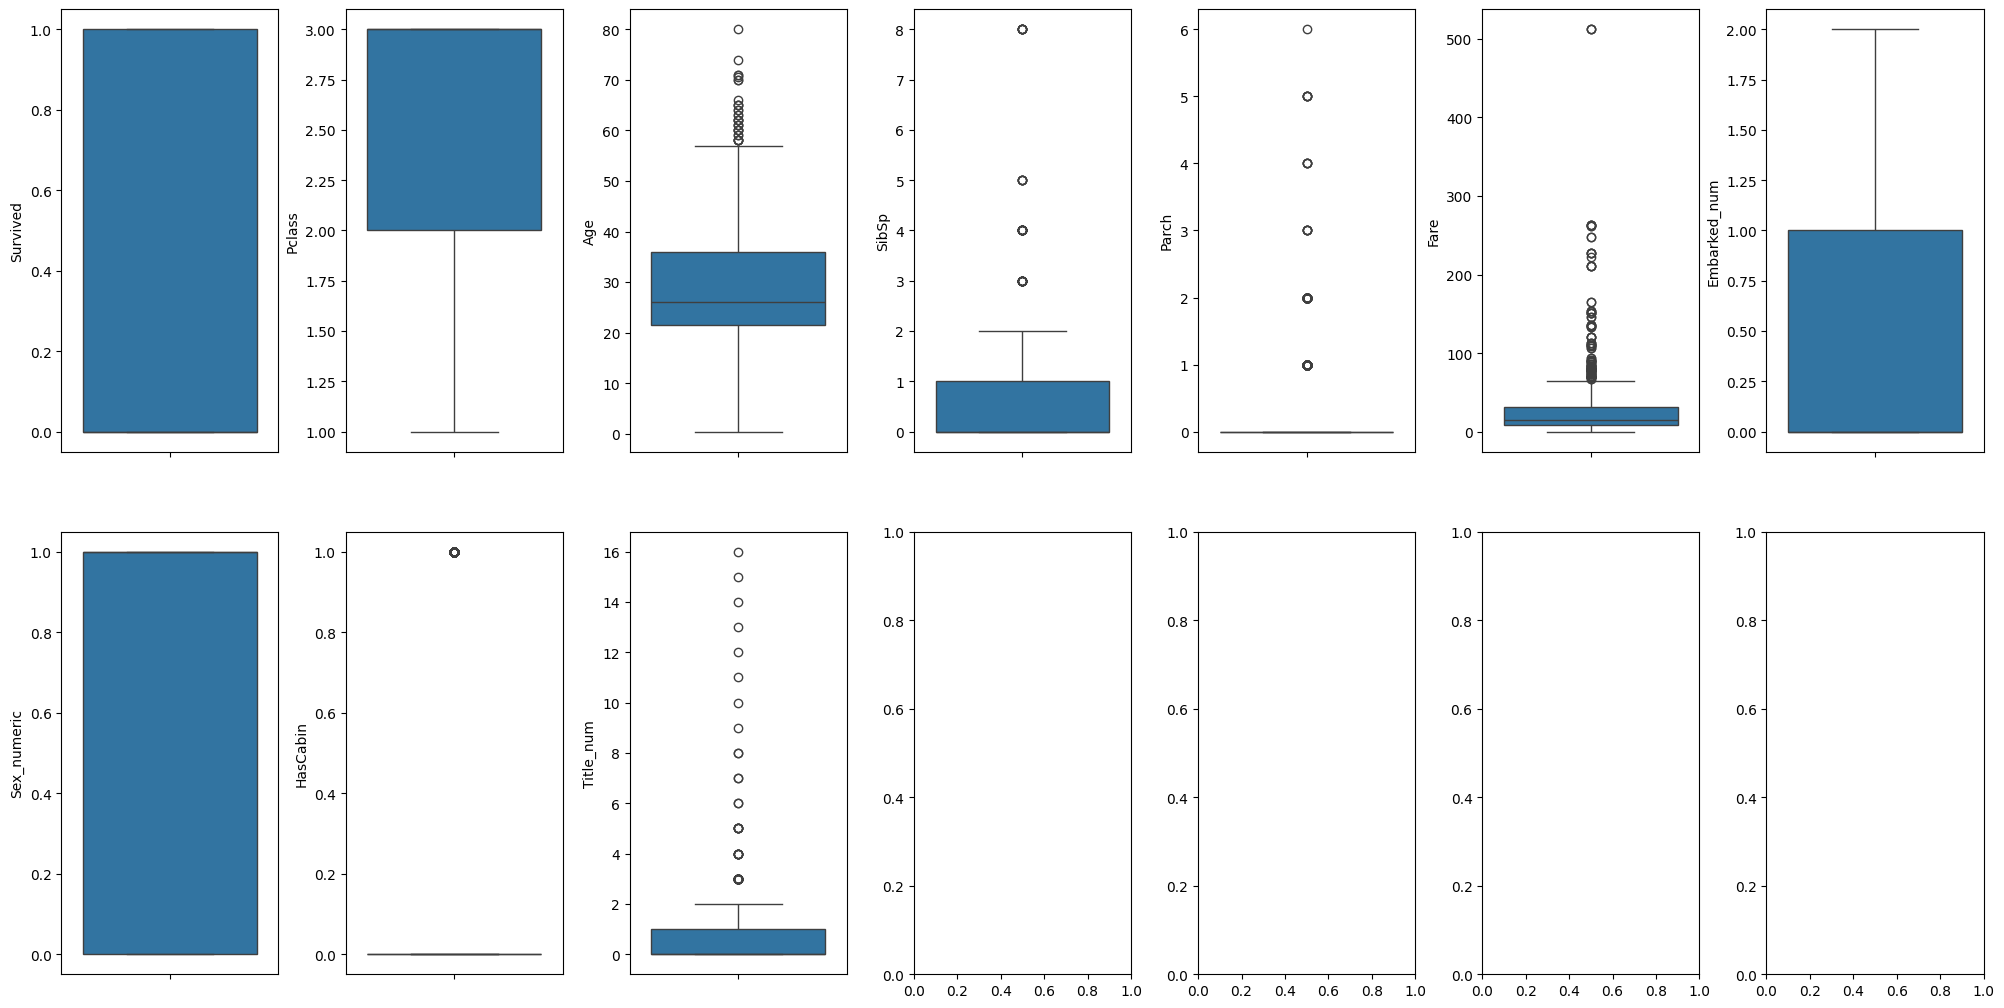

In [1828]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Логорифмируем стоимость

   Survived  Pclass   Age  SibSp  Parch  Embarked_num  Sex_numeric  HasCabin  \
0         0       3  22.0      1      0             0            1     False   
1         1       1  38.0      1      0             1            0      True   
2         1       3  26.0      0      0             0            0     False   
3         1       1  35.0      1      0             0            0      True   
4         0       3  35.0      0      0             0            1     False   

   Title_num  Fare_log  
0          0  2.110213  
1          2  4.280593  
2          1  2.188856  
3          2  3.990834  
4          0  2.202765  


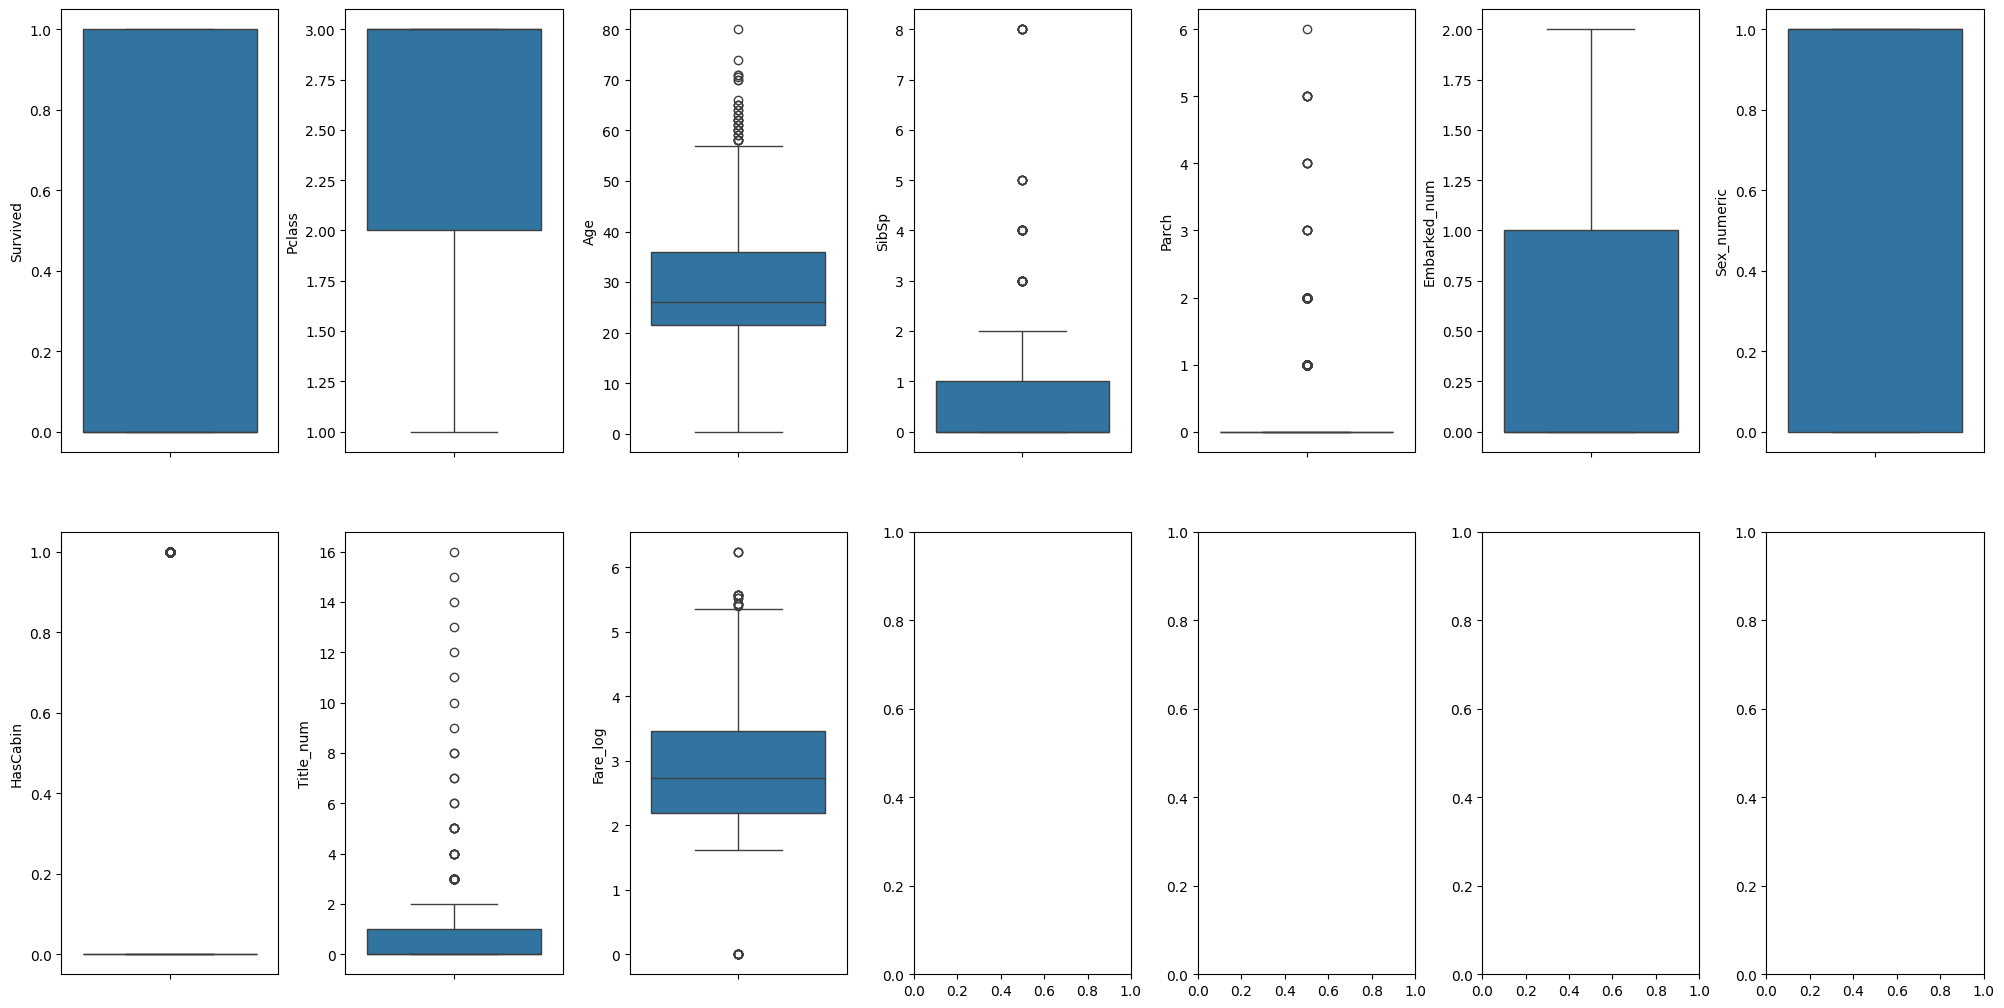

In [1829]:
df['Fare_log'] = np.log1p(df['Fare'])
df.drop(columns=['Fare'], inplace=True) # Удаляем оригинальную колонку
print(df.head())

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Подготовка данных закончена. НАчинаю анализ

In [1830]:
# Анализ корреляции между признаками и целевой переменной
# corr(): вычисляет матрицу корреляции Пирсона между всеми числовыми колонками
correlation_matrix = df.corr()

# Сортировка корреляций с целевой переменной Survived по убыванию
# sort_values(ascending=False): сортирует значения по убыванию
target_correlation = correlation_matrix['Survived'].sort_values(ascending=False)
abs_correlation = target_correlation.drop('Survived').abs().sort_values(ascending=False)


print("Корреляция признаков с ценой (Survived):")
print(target_correlation)

# Тепловая карта корреляций
# px.imshow: создает heatmap (тепловую карту)
# correlation_matrix.round(2): матрица корреляции, округленная до 2 знаков
# color_continuous_scale='RdBu_r': цветовая шкала от синего к красному (reversed)
# aspect="auto": автоматическое соотношение сторон
# text_auto=True: автоматическое отображение значений в ячейках

fig = px.imshow(correlation_matrix.round(2),
                title='Матрица корреляции признаков',
                aspect="auto",
                color_continuous_scale='RdBu_r',
                text_auto=True)
fig.update_layout(width=800, height=800)  # Размер графика
fig.show()

Корреляция признаков с ценой (Survived):
Survived        1.000000
Fare_log        0.329862
HasCabin        0.316912
Title_num       0.296165
Embarked_num    0.106811
Parch           0.081629
SibSp          -0.035322
Age            -0.059579
Pclass         -0.338481
Sex_numeric    -0.543351
Name: Survived, dtype: float64


In [1831]:
# Анализ самых значимых признаков (топ-3 кроме самой цены)
# target_correlation.index[1:4]: берем индексы с 1 по 3 (исключая Survived на позиции 0)
top_features = target_correlation.index[1:4]
print(top_features)
top_abs = abs_correlation.index[:5]
print(top_abs)

# Создание subplots с 1 строкой и 3 колонками
# subplot_titles: заголовки для каждого subplot
fig = make_subplots(rows=1, 
                    cols=len(top_features),
                    subplot_titles=[f"{feat} vs Survived" for feat in top_features])

# Добавление scatter plots для каждого признака
for i, feature in enumerate(top_features, 1):  # enumerate начинается с 1 для нумерации колонок
    fig.add_trace(
        go.Scatter(
            x=df[feature],  # данные по оси X (признак)
            y=df['Survived'],   # данные по оси Y (цена)
            mode='markers', # режим отображения - точки
            name=feature,   # название для легенды
            marker=dict(size=5, opacity=0.6)  # настройки маркеров: размер и прозрачность
        ),
        row=1, col=i  # позиция в subplot
    )
    fig.update_xaxes(title_text=feature, row=1, col=i)  # подпись оси X
    fig.update_yaxes(title_text="Survived", row=1, col=i)   # подпись оси Y

fig.update_layout(
    height=400,      # высота графика
    width=1200,      # ширина графика
    title_text="Взаимосвязь топ-3 наиболее коррелирующих признаков с ценой",
    showlegend=False # скрыть легенду (не нужна для отдельных графиков)
)
fig.show()

Index(['Fare_log', 'HasCabin', 'Title_num'], dtype='object')
Index(['Sex_numeric', 'Pclass', 'Fare_log', 'HasCabin', 'Title_num'], dtype='object')


In [1832]:
# Сначала проверим, какие столбцы действительно есть в DataFrame
print("Столбцы в DataFrame:")
print(df.columns.tolist())

# Проверим наличие каждого предполагаемого столбца
key_features = ['Pclass',  'Sex_numeric', 'Fare_log']

print("\nПроверка наличия столбцов:")
for feature in key_features + ['Survived']:
    if feature in df.columns:
        print(f"✓ {feature} - присутствует")
    else:
        print(f"✗ {feature} - отсутствует")

# Создадим список только существующих столбцов
existing_features = [feature for feature in key_features if feature in df.columns]
print(f"\nСуществующие признаки: {existing_features}")

Столбцы в DataFrame:
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Embarked_num', 'Sex_numeric', 'HasCabin', 'Title_num', 'Fare_log']

Проверка наличия столбцов:
✓ Pclass - присутствует
✓ Sex_numeric - присутствует
✓ Fare_log - присутствует
✓ Survived - присутствует

Существующие признаки: ['Pclass', 'Sex_numeric', 'Fare_log']


In [1833]:
# Более детальный анализ ключевых признаков
key_features = ['Pclass',  'Sex_numeric', 'Fare_log'] # Выбранные ключевые признаки

# Матрица scatter plots
# px.scatter_matrix: создает матрицу scatter plots для выбранных измерений
# dimensions: список колонок для анализа
# color='Survived': цвет точек based on цены
# color_continuous_scale: цветовая шкала
# title: заголовок графика

fig = px.scatter_matrix(df, 
                        dimensions=key_features + ['Survived'],
                        title='Матрица scatter plot ключевых признаков Boston Housing',
                        color='Survived',
                        color_continuous_scale='viridis',
                        height=800)  # высота графика
fig.show()

In [1834]:
gender_survival = pd.crosstab(df['Sex_numeric'], df['Survived'])
gender_survival_percentage = pd.crosstab(df['Sex_numeric'], df['Survived'], normalize='index') * 100

print("Выживаемость по полу:")
print(gender_survival)
print("\nПроцент выживаемости по полу:")
print(gender_survival_percentage)


fig = px.histogram(df, x='Sex_numeric', color='Survived', barmode='group',
                   title='Выживаемость по полу',
                   labels={'Survived': 'Выжил', 'Sex_numeric': 'Пол'},
                   color_discrete_sequence=['red', 'green'])
fig.update_layout(bargap=0.2)
fig.show()

Выживаемость по полу:
Survived       0    1
Sex_numeric          
0             81  233
1            468  109

Процент выживаемости по полу:
Survived             0          1
Sex_numeric                      
0            25.796178  74.203822
1            81.109185  18.890815


In [1835]:
class_survival = pd.crosstab(df['Pclass'], df['Survived'])
class_survival_percentage = pd.crosstab(df['Pclass'], df['Survived'], normalize='index') * 100

print("Выживаемость по классу:")
print(class_survival)
print("\nПроцент выживаемости по классу:")
print(class_survival_percentage)


fig = px.histogram(df, x='Pclass', color='Survived', barmode='group',
                   title='Выживаемость по классу',
                   labels={'Survived': 'Выжил', 'Pclass': 'Класс'},
                   color_discrete_sequence=['red', 'green'])
fig.update_layout(bargap=0.2)
fig.show()

Выживаемость по классу:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Процент выживаемости по классу:
Survived          0          1
Pclass                        
1         37.037037  62.962963
2         52.717391  47.282609
3         75.763747  24.236253


In [1836]:

print("Статистика по возрасту:")
print(df['Age'].describe())

fig = px.histogram(df, x='Age', color='Survived', nbins=30,
                   title='Распределение возраста по выживаемости',
                   marginal='box',
                   opacity=0.7,
                   color_discrete_sequence=['red', 'green'])
fig.show()

Статистика по возрасту:
count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64


In [1837]:
# Анализ возраста по полу и выживаемости
fig = px.box(df, x='Sex_numeric', y='Age', color='Survived',
             title='Распределение возраста по полу и выживаемости',
             color_discrete_sequence=['red', 'green'])
fig.show()

In [1838]:

print("Статистика по стоимости билета:")
print(df['Fare_log'].describe())


fig = px.histogram(df, x='Fare_log', color='Survived', nbins=30,
                   title='Распределение стоимости билета по выживаемости',
                   marginal='box',
                   opacity=0.7,
                   color_discrete_sequence=['red', 'green'])
fig.show()

Статистика по стоимости билета:
count    891.000000
mean       2.962246
std        0.969048
min        0.000000
25%        2.187218
50%        2.737881
75%        3.465736
max        6.240917
Name: Fare_log, dtype: float64


In [1839]:

embarked_survival = pd.crosstab(df['Embarked_num'], df['Survived'])
embarked_survival_percentage = pd.crosstab(df['Embarked_num'], df['Survived'], normalize='index') * 100

print("Выживаемость по порту посадки:")
print(embarked_survival)
print("\nПроцент выживаемости по порту посадки:")
print(embarked_survival_percentage)


fig = px.histogram(df, x='Embarked_num', color='Survived', barmode='group',
                   title='Выживаемость по порту посадки',
                   labels={'Survived': 'Выжил', 'Embarked_num': 'Порт посадки'},
                   color_discrete_sequence=['red', 'green'])
fig.show()

Выживаемость по порту посадки:
Survived        0    1
Embarked_num          
0             427  219
1              75   93
2              47   30

Процент выживаемости по порту посадки:
Survived              0          1
Embarked_num                      
0             66.099071  33.900929
1             44.642857  55.357143
2             61.038961  38.961039


In [1840]:
# Анализ по возрастным группам

df['AgeGroup'] = pd.cut(df['Age'], 
                             bins=[0, 12, 18, 35, 60, 100], 
                             labels=[0, 1, 2, 3, 4])

# Анализ выживаемости по возрастным группам
agegroup_survival = pd.crosstab(df['AgeGroup'], df['Survived'], normalize='index') * 100

print("Выживаемость по возрастным группам:")
print(agegroup_survival)

# Визуализация
fig = px.histogram(df, x='AgeGroup', color='Survived', barmode='group',
                   title='Выживаемость по возрастным группам',
                   color_discrete_sequence=['red', 'green'])
fig.show()

Выживаемость по возрастным группам:
Survived          0          1
AgeGroup                      
0         42.028986  57.971014
1         57.142857  42.857143
2         64.202335  35.797665
3         61.574074  38.425926
4         77.272727  22.727273


Выводы: 
1. Чем выше класс , тем выше вероятность выжить. Во втором классе 50/50
1.1. Чем выше стоимость билета, тем выше вероятность выжить
2. До 12 лет вероятность выжить самая высокая, после 60 самая низкая
3. Если сесть на вокзале "С", то вероятность выжить больше, чем на других вокзалах
4. Мужчины умерали чаще, чем женщины

Модель выживаемости

In [1841]:
def predict_survival_probability(passenger_row):
    """
    Предсказывает вероятность выживания.
    Работает со строкой датасета pandas.
    
    Parameters:
    passenger_row (pd.Series): Строка датасета с данными пассажира.
                               Должна содержать колонки: Sex, Pclass, Age, 
                               Embarked
    
    Returns:
    float: Вероятность выживания от 0.0 до 1.0
    """
    
    # Базовые вероятности выживания из исторических данных
    base_probability = 0.38  # Общая вероятность выживания
    
    # Модификаторы на основе факторов
    modifiers = 0.0
    weight_sex = 0.9
    weight_pclass = 0.8
    weight_age = 0.7
    weight_embarked = 0.6

    max_probability = 0.74*weight_sex + 0.6*weight_pclass + 0.6*weight_age + 0.5*weight_embarked
    
    # 1. Пол 
    sex = passenger_row.get('Sex')
    if pd.notna(sex):
        if sex == 'female':
            modifiers += 0.74  # Женщины имели высокий шанс выживания
        elif sex == 'male':
            modifiers += 0.18  # Мужчины имели низкий шанс
        modifiers *= weight_sex
    
    # 2. Класс
    pclass = passenger_row.get('Pclass')
    if pd.notna(pclass):
        if pclass == 1:
            modifiers += 0.6  # Первый класс - высокий шанс
        elif pclass == 2:
            modifiers += 0.4  # Второй класс - средний шанс
        elif pclass == 3:
            modifiers += 0.2  # Третий класс - низкий шанс
        modifiers *= weight_pclass
    
    # 3. Возраст
    age = passenger_row.get('Age')
    if pd.notna(age):
        if age < 12:  # Дети
            modifiers += 0.60
        elif age > 60:  # Пожилые
            modifiers -= 0.20
        modifiers *= weight_age
    
    # 4. Порт посадки (опционально)
    embarked = passenger_row.get('Embarked')
    if pd.notna(embarked):
        if embarked == 'C':  
            modifiers += 0.5
        modifiers *= weight_embarked

    
    # Вычисляем итоговую вероятность
    probability = base_probability + modifiers
    
    # Ограничиваем вероятность в диапазоне [0, 1]
    probability =  probability/max_probability
    
    return round(probability, 2)

In [1842]:
      
for i, (_, row) in enumerate(df_test.iterrows()):
    prob = predict_survival_probability(row)
    print(f"Пассажир {i+1}: {prob * 100}%")
    print(f"  Данные: {dict(row)}")
    print()

Пассажир 1: 27.0%
  Данные: {'PassengerId': 1, 'Survived': 0, 'Pclass': 3, 'Name': 'Braund, Mr. Owen Harris', 'Sex': 'male', 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Ticket': 'A/5 21171', 'Fare': 7.25, 'Cabin': nan, 'Embarked': 'S'}

Пассажир 2: 59.0%
  Данные: {'PassengerId': 2, 'Survived': 1, 'Pclass': 1, 'Name': 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Sex': 'female', 'Age': 38.0, 'SibSp': 1, 'Parch': 0, 'Ticket': 'PC 17599', 'Fare': 71.2833, 'Cabin': 'C85', 'Embarked': 'C'}

Пассажир 3: 36.0%
  Данные: {'PassengerId': 3, 'Survived': 1, 'Pclass': 3, 'Name': 'Heikkinen, Miss. Laina', 'Sex': 'female', 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Ticket': 'STON/O2. 3101282', 'Fare': 7.925, 'Cabin': nan, 'Embarked': 'S'}

Пассажир 4: 43.0%
  Данные: {'PassengerId': 4, 'Survived': 1, 'Pclass': 1, 'Name': 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'Sex': 'female', 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Ticket': '113803', 'Fare': 53.1, 'Cabin': 'C123', 'Embarked': 'S'}

Пассажир 5

In [1843]:
df.drop(columns=['SibSp','Age','Parch','HasCabin','Title_num',], inplace=True) # Удаляем оригинальную колонку

y = df['Survived'].to_numpy()
df.drop(columns=['Survived'], inplace=True)
X = df.to_numpy()
print(df.head())


test_size = 0.1

row_count = X.shape[0] 
row_count_in_samples = int(row_count * test_size)

indixes = np.random.permutation(row_count)

test_indices = indixes[:row_count_in_samples]
train_indices = indixes[row_count_in_samples:]


X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]


   Pclass  Embarked_num  Sex_numeric  Fare_log AgeGroup
0       3             0            1  2.110213        2
1       1             1            0  4.280593        3
2       3             0            0  2.188856        2
3       1             0            0  3.990834        2
4       3             0            1  2.202765        2


In [ ]:
def linear_regression(
        X: np.ndarray,
        y: np.ndarray,
        learning_rate: float = 0.01,
        iterations: int = 5000,
        coef_umensheniya_learning_rate: float = 0.001,
        epsilon: float = 1e-4
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Линейная регрессия.

    :param X: Исходная матрица.
    :param y: Целевые значения.
    :param learning_rate: Начальная скорость.
    :param iterations: максимальное количество итераций.
    :param coef_umensheniya_learning_rate: Коэффициент уменьшения скорости сходимости.
    :param epsilon: показатель качества модели для досрочного выхода из обучения.
    :return: Кортеж: 
        - weights: Веса.
        - X_mean: Средние значения.
        - X_std: Стандартные отклонения.
    """
    # нормализация признаков
    X_mean = np.mean(X, axis=0 )
    X_std = np.std(X, axis=0)
    # Избегаем деления на ноль
    X_std[X_std == 0] = 1
    X_normalized = (X - X_mean) / X_std
    
    # Добавление столбца единиц для свободного члена
    row, col = X_normalized.shape
    #X_b = np.column_stack([np.ones(row), X_normalized])
    X_b = X_normalized

    weights = np.random.randn(col + 1)

    for i in range(iterations):
        y_pred = X_b @ weights
        error = y_pred - y

        gradient = (2 / row) * X_b.T @ error
        current_lr = learning_rate#learning_rate * (1 / (1 + coef_umensheniya_learning_rate * i))
        old_weights = weights.copy()
        weights = weights - current_lr * gradient

        # Проверяем изменение весов
        weight_change = np.linalg.norm(weights - old_weights)
        
        if weight_change < epsilon:
            print(f"Сходимость достигнута на итерации {i}, изменение весов: {weight_change:.2e}")
            break

        if i == iterations - 1:
            print(f"Заданная точность НЕ достигнута за {iterations} шагов, последнее изменение весов: {weight_change:.2e}")
    
    return weights, X_mean, X_std

def predict(X, weights, X_mean, X_std):
    """
    Предсказание.
    
    :param X: Исходная матрица.
    :param weights: Веса.
    :param X_mean:Средние значения.
    :param X_std: Стандартные отклонения.
    :return: Предсказание.
    """
    X_normalized = (X - X_mean) / X_std
    row = X_normalized.shape[0]
    X_b = np.column_stack([np.ones(row), X_normalized])
    return X_b @ weights

def sigmoid(z):
    # Ограничиваем z, чтобы избежать переполнения
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def predict_logistic(X, weights, X_mean, X_std, threshold=0.5):
    """
    Предсказывает.

    :param X: Исходная матрица.
    :param weights: Веса.
    :param X_mean: Средние значения.
    :param X_std: Стандартные отклонения
    :param threshold: Порог для бинарной классификации.
    :return: Кортеж: 
        - probabilities: вероятности.
        - predict_class: предсказание класса бинарной классификации.
    """
    X_normalized = (X - X_mean) / X_std
    row = X_normalized.shape[0]
    X_b = np.column_stack([np.ones(row), X_normalized])
    
    z = X_b @ weights
    probabilities = sigmoid(z)
    predict_class = (probabilities >= threshold).astype(int)

    return probabilities, predict_class

In [1845]:
weights, X_mean, X_std = linear_regression(X_train, y_train, learning_rate=0.1, iterations=250000, coef_umensheniya_learning_rate=0.001, epsilon=1e-10)


probs, y_predict = predict_logistic(X_test, weights, X_mean, X_std, threshold=0.6)

Сходимость достигнута на итерации 378, изменение весов: 9.65e-11


In [1852]:
regression = LogisticRegression()

regression.fit(X_train, y_train)

y_predict_sk = regression.predict(X_test)

regression.score(X_test, y_test)

0.797752808988764

Точность

In [1847]:
(y_test == y_predict).sum()/y_test.shape[0]

np.float64(0.7640449438202247)

In [1850]:
df_result = pd.DataFrame(
    X_test,
    columns=df.columns
)

df_result['pred_Survived'] = y_predict
df_result['pred_Survived_SK'] = y_predict_sk
df_result['pred_Probs'] = probs
#df_result['pred_Probs_SK'] = regression.coef_

df_result.head(20)
print(regression.coef_)
print(weights)


[[-1.23691515  0.27028463 -2.47745402 -0.04372187 -0.55101937]]
[ 0.37905237 -0.16933315  0.02614986 -0.2327324  -0.01296661 -0.07455971]


In [ ]:
train_score = regression.score(X_train, y_train)
test_score = regression.score(X_test, y_test)
gap = train_score - test_score
print(f'Norm model gap: {gap:.4f} (train: {train_score:.4f}, test: {test_score:.4f})')

Norm model gap: 0.0277 (train: 0.8142, test: 0.7865)


Переобучение

In [ ]:
test_size_overlearning = 0.99

row_count = X.shape[0] 
row_count_in_samples_overlearning = int(row_count * test_size_overlearning)

indixes_overlearning  = np.random.permutation(row_count)

test_indices_overlearning = indixes_overlearning [:row_count_in_samples_overlearning]
train_indices_overlearning  = indixes_overlearning [row_count_in_samples_overlearning:]


X_train_overlearning , X_test_overlearning  = X[train_indices_overlearning ], X[test_indices_overlearning ]
y_train_overlearning , y_test_overlearning  = y[train_indices_overlearning ], y[test_indices_overlearning ]


regression_overlearning = LogisticRegression()
regression_overlearning.fit(X_train_overlearning, y_train_overlearning)

y_predict_sk_overlearning = regression_overlearning.predict(X_test_overlearning)

print(f'On train data: {regression_overlearning.score(X_train_overlearning, y_train_overlearning)}\nOn test  data: {regression_overlearning.score(X_test_overlearning, y_test_overlearning)}') 

train_score_overlearning = regression_overlearning.score(X_train_overlearning, y_train_overlearning)
test_score_overlearning = regression_overlearning.score(X_test_overlearning, y_test_overlearning)
gap_overlearning = train_score_overlearning - test_score_overlearning
print(f'Overlearning model gap: {gap_overlearning:.4f} (train: {train_score_overlearning:.4f}, test: {test_score_overlearning:.4f})')

On train data: 1.0
On test  data: 0.7562358276643991
Overlearning model gap: 0.2438 (train: 1.0000, test: 0.7562)


Недообучение

In [ ]:
test_size_underlearning = 0.9

row_count = X.shape[0] 
row_count_in_samples_underlearning = int(row_count * test_size_underlearning)

indixes_underlearning  = np.random.permutation(row_count)

test_indices_underlearning = indixes_underlearning [:row_count_in_samples_underlearning]
train_indices_underlearning  = indixes_underlearning [row_count_in_samples_underlearning:]


X_train_underlearning , X_test_underlearning  = X[train_indices_underlearning ], X[test_indices_underlearning ]
y_train_underlearning , y_test_underlearning  = y[train_indices_underlearning ], y[test_indices_underlearning ]


regression_underlearning = LogisticRegression(max_iter=1)
regression_underlearning.fit(X_train_underlearning, y_train_underlearning)

y_predict_sk_underlearning = regression_underlearning.predict(X_test_underlearning)

print(f'On train data: {regression_underlearning.score(X_train_underlearning, y_train_underlearning)}\nOn test  data: {regression_underlearning.score(X_test_underlearning, y_test_underlearning)}') 

train_score_underlearning = regression_underlearning.score(X_train_underlearning, y_train_underlearning)
test_score_underlearning = regression_underlearning.score(X_test_underlearning, y_test_underlearning)
gap_underlearning = train_score_underlearning - test_score_underlearning
print(f'Overlearning model gap: {gap_underlearning:.4f} (train: {train_score_underlearning:.4f}, test: {test_score_underlearning:.4f})')

On train data: 0.5777777777777777
On test  data: 0.6204744069912609
Overlearning model gap: -0.0427 (train: 0.5778, test: 0.6205)
